# Generating a non-stationary dataset

Basically, we just take a sum of two GPs ($f_1$ and $f_2$), in which the value at each point is:

$$f(s_i) = w_if_1(s_i) + (1-w_i) f_2 (s_i)$$

subject to some constraints on $w$ (at each point $s_i$, the weights should sum to 1).

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import kernels

# Define the kernel
x_range = np.linspace(-1, 1, 50)
y_range = np.linspace(-1, 1, 50)

X1, X2 = np.meshgrid(x_range, y_range)
X = np.vstack((X1.ravel(), X2.ravel())).T

k1 = kernels.RBF(length_scale = 0.1) # rougher edges
k2 = kernels.RBF(length_scale = 0.5) # smoother edges

k1_true = k1(X)
k2_true = k2(X)

m1 = np.random.multivariate_normal(np.zeros(X.shape[0]), k1_true).reshape(X1.shape)
m2 = np.random.multivariate_normal(np.zeros(X.shape[0]), k2_true).reshape(X1.shape)

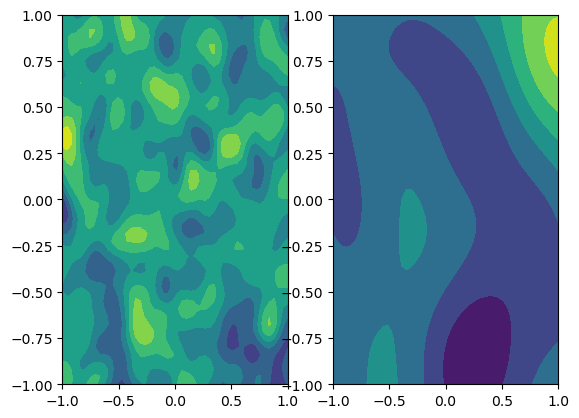

In [6]:
plt.subplot(1,2,1)
plt.contourf(X1, X2, m1)
plt.subplot(1,2,2)
plt.contourf(X1, X2, m2)

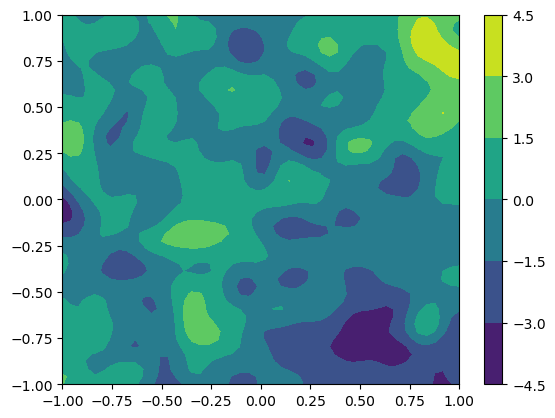

In [7]:
plt.contourf(X1, X2, m1 + m2)
plt.colorbar()

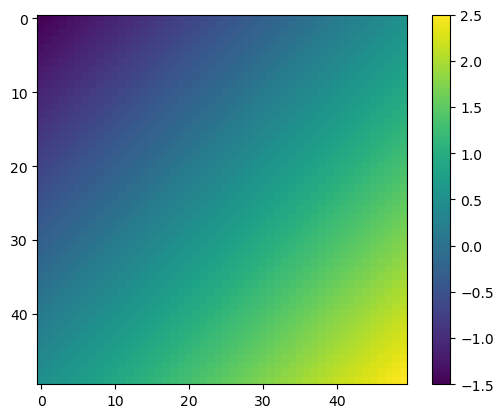

In [8]:
# How to generate the w piece
y = X1 + X2
w = y - y.min() / (y.max() - y.min())
plt.imshow(w)
plt.colorbar()

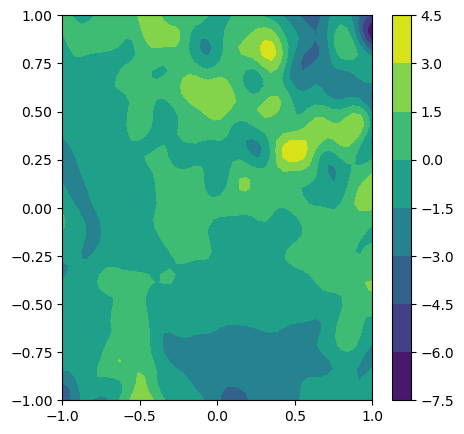

In [9]:
# Plot the non-stationary kernel
f = w * m1 + (1-w) * m2
plt.figure(figsize=(5,5))
plt.contourf(X1, X2, f)
plt.colorbar()

In [19]:
f.ravel().shape, X.shape

((2500,), (2500, 2))

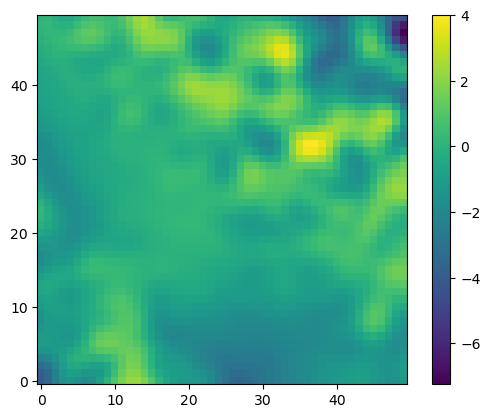

In [10]:
plt.imshow(f, origin='lower')
plt.colorbar()

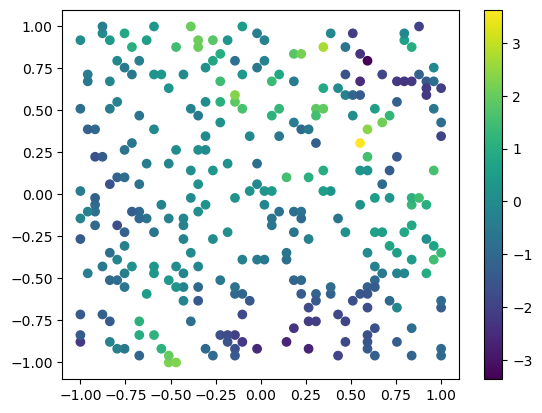

In [33]:
observed_coords = np.random.choice(X.shape[0], 300, replace=False)
plt.scatter(X[observed_coords, 0], X[observed_coords, 1], c=f.flatten()[observed_coords])
plt.colorbar()
plt.show()

In [3]:
cd ..

/Users/student/Code/uhi-deep-learning


In [14]:
# Now import your module
from src.models import NonStationaryGPModel
import gpytorch
import torch
import itertools
import numpy as np
import matplotlib.pyplot as plt
from gpytorch.kernels import Kernel, MaternKernel

In [34]:
train_x = X[observed_coords]
train_x.shape

(300, 2)

In [40]:
# Function to train the model
def train_model(train_x, train_y, likelihood, num_points=16):
    model = NonStationaryGPModel(train_x, train_y, likelihood, num_points)
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    best_loss = float('inf')
    params = None

    print(f"RBF Centers: \n{model.covar_module.rbf_centers.detach().numpy()}")

    for i in range(50):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()

        print(f"Iter {i+1}/50 - Loss: {loss.item():.3f}")
        print(f"Base Kernel Lengthscale: \n{model.covar_module.base_kernel.lengthscale.item()}")
        print(f"RBF Widths: \n{model.covar_module.raw_rbf_widths.detach().numpy()}")
        print(f"Signal Variance: \n{model.covar_module.coefficients.detach().numpy()}")

        if loss.item() < best_loss:
            print('Saving model parameters...')
            best_loss = loss.item()
            params = model.state_dict()

        optimizer.step()

    return model, params

In [42]:
# Convert training data to PyTorch tensors
train_x = torch.tensor(X[observed_coords], dtype=torch.float32)
train_y = torch.tensor(f.ravel()[observed_coords], dtype=torch.float32)

# Define likelihood and GP model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Train the GP model using your Non-Stationary Kernel
trained_model, _ = train_model(train_x, train_y, likelihood, num_points=25)

RBF Centers: 
[[0.   0.  ]
 [0.   0.25]
 [0.   0.5 ]
 [0.   0.75]
 [0.   1.  ]
 [0.25 0.  ]
 [0.25 0.25]
 [0.25 0.5 ]
 [0.25 0.75]
 [0.25 1.  ]
 [0.5  0.  ]
 [0.5  0.25]
 [0.5  0.5 ]
 [0.5  0.75]
 [0.5  1.  ]
 [0.75 0.  ]
 [0.75 0.25]
 [0.75 0.5 ]
 [0.75 0.75]
 [0.75 1.  ]
 [1.   0.  ]
 [1.   0.25]
 [1.   0.5 ]
 [1.   0.75]
 [1.   1.  ]]
Iter 1/50 - Loss: 1.457
Base Kernel Lengthscale: 
0.6931471824645996
RBF Widths: 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Signal Variance: 
[ 0.41898134  0.27821237  0.11601709 -0.35958079 -2.0634675  -0.540079
 -1.171852   -0.5053534  -2.1794052   0.43567696  0.9403284   0.49506974
  0.5990026   0.7645977  -1.8143605   0.19338387 -0.2629859   1.7005316
 -0.33022183 -0.0782886   0.8737118  -0.94064236 -0.0755978  -0.07286889
 -0.3105271 ]
Saving model parameters...
Iter 2/50 - Loss: 1.346
Base Kernel Lengthscale: 
0.6443966627120972
RBF Widths: 
[1.0999999  1.0999999  1.0999999  0.90000004 0.90000004 0.90000004
 0.

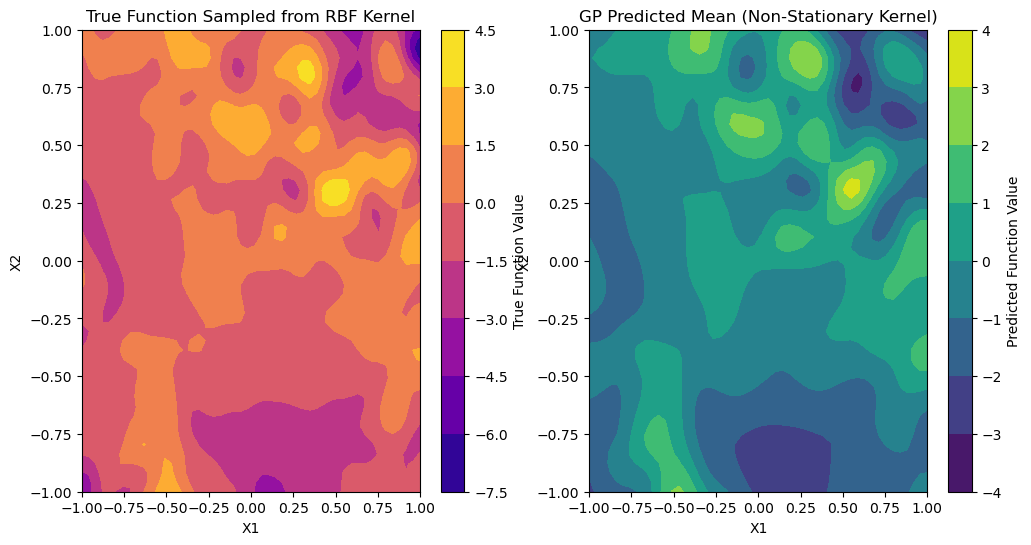

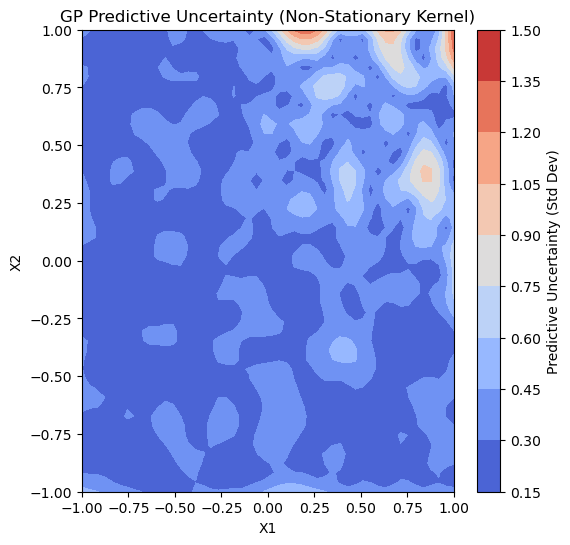

In [37]:
# Function to generate predictions using the trained GP model
def generate_predictions(model, likelihood, test_x):
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        predictive_dist = likelihood(model(test_x))  # GP predictive distribution
        mean_pred = predictive_dist.mean.numpy()

        # Directly extract diagonal variance from covariance matrix
        std_pred = torch.sqrt(predictive_dist.covariance_matrix.diagonal()).numpy()

    return mean_pred, std_pred

# Generate a grid of test points
test_x = torch.tensor(X, dtype=torch.float32)

# Generate predictions for test points
mean_pred, std_pred = generate_predictions(trained_model, likelihood, test_x)

# Reshape predictions to match the grid
mean_pred_reshaped = mean_pred.reshape(X1.shape)
std_pred_reshaped = std_pred.reshape(X1.shape)

# Plot True Function vs. Predicted Mean
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# True function (from synthetic RBF data)
contour1 = ax[0].contourf(X1, X2, f, cmap="plasma")
fig.colorbar(contour1, ax=ax[0], label="True Function Value")  # Corrected

ax[0].set_title("True Function Sampled from RBF Kernel")
ax[0].set_xlabel("X1")
ax[0].set_ylabel("X2")

# GP predicted mean
contour2 = ax[1].contourf(X1, X2, mean_pred_reshaped, cmap="viridis")
fig.colorbar(contour2, ax=ax[1], label="Predicted Function Value")  # Corrected

ax[1].set_title("GP Predicted Mean (Non-Stationary Kernel)")
ax[1].set_xlabel("X1")
ax[1].set_ylabel("X2")

plt.show()

# Plot Standard Deviation (Uncertainty Estimates)
plt.figure(figsize=(6, 6))
contour3 = plt.contourf(X1, X2, std_pred_reshaped, cmap="coolwarm")
plt.colorbar(label="Predictive Uncertainty (Std Dev)")
plt.title("GP Predictive Uncertainty (Non-Stationary Kernel)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error

# Compute RMSE between true function values and GP predicted mean
rmse = np.sqrt(mean_squared_error(f.ravel(), mean_pred))

# Print RMSE
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 0.4833
